# Large Data Limits & Rescaled t-SNE

### Setup

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE

In [67]:
# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets

## Helper Functions

### running standard and rescaled t-SNE

In [68]:
def run_rescaled_tsne(data, seed, kappa=30, alpha=0.1, b=0.15):
    """
    Run t-SNE with a rescaled perplexity and exaggeration factor.

    Parameters:
      - data: ndarray of shape (n_samples, n_features)
      - kappa: base constant (effective number of neighbors)
      - alpha: exponent to allow perplexity to grow as n^alpha
      
    Returns:
      - embedding: 2D embedding from t-SNE.
    """
    n, d = data.shape
    # Note: b needs to be larger than 1/d and smaller than 1 
    h_n = n ** (-b)
    # Perplexity should be chosen to scale slowly with n.
    scaled_perplexity = kappa * (n ** alpha)
    # Early exaggeration factor: rescale the attractive term by 1/h_n^2.
    exaggeration = 1 / (h_n ** 2)
    
    print(f"n = {n}, d = {d}, b={b}")
    print(f"Computed h_n = {h_n:.4f}")
    print(f"Using perplexity = {scaled_perplexity:.2f} (base κ = {kappa}, exponent α = {alpha})")
    print(f"Using early exaggeration = {exaggeration:.2f}")

    # keep on EE for the entirety of the optimization  
    tsne = TSNE(
        perplexity=scaled_perplexity,
        early_exaggeration=exaggeration,
        exaggeration=exaggeration, 
        n_jobs=-1,
        random_state=seed,
        verbose=False
    )
    embedding = tsne.fit(data)
    return embedding

In [69]:
def run_standard_tsne(data, seed):
    """
    Run standard t-SNE with fixed perplexity and exaggeration.
    """
    tsne = TSNE(n_jobs=-1, random_state=seed, verbose=False)
    return tsne.fit(data)

### sampling points from mixture of Gaussians

In [70]:
def sample_gaussian_mixture(n_samples: int, dim: int, n_components: int = 5, spread: float = 5.0):
    """
    Generates samples from a Gaussian Mixture Model with equidistant Gaussian components in high dimensions.

    Parameters:
    - n_samples (int): Total number of samples to generate.
    - dim (int): Dimensionality of the data.
    - n_components (int): Number of Gaussian components (default: 5).
    - spread (float): Controls how far apart the Gaussian centers are (default: 5.0).

    Returns:
    - X (numpy.ndarray): Sampled data of shape (n_samples, dim).
    - labels (numpy.ndarray): Cluster labels for each sample.
    """
    np.random.seed(42)

    # Generate random Gaussian centers in high-dimensional space
    means = np.random.randn(n_components, dim) * spread  # Spread them apart

    # Covariance matrices (identity matrices for simplicity)
    covariances = [np.eye(dim) for _ in range(n_components)]

    # Equal mixing probabilities (each Gaussian has 1/n_components probability)
    component_choices = np.random.choice(n_components, size=n_samples, p=np.ones(n_components) / n_components)

    # Sample from the selected Gaussians
    X = np.array([np.random.multivariate_normal(means[comp], covariances[comp]) for comp in component_choices])

    return X, component_choices  # Return data and the labels indicating which Gaussian each point came from


### Embedding Dict (running both standard and rescaled tSNE on different sample sizes and seeds)

In [71]:
def generate_embedding_dict_gaussian(gaussian_data, sample_sizes, seeds, b=0.15, kappa=30):

    embeddings = {}
    for i, n in enumerate(sample_sizes):
        X, y = gaussian_data[i]
        # Generate synthetic data
        for seed in seeds: 
            # Compute embeddings
            emb_standard = run_standard_tsne(X, seed)
            emb_rescaled = run_rescaled_tsne(X, seed, kappa=kappa, alpha=0.05, b=b)
            
            embeddings[(n, (seed, "standard"))] = (emb_standard, y)
            embeddings[(n, (seed, "rescaled"))] = (emb_rescaled, y)
    
    return embeddings

In [72]:
def generate_embedding_dict_mnist(n_samples, seeds, b=0.15, kappa=30):
    X, y = datasets.load_mnist()
    embeddings = {}
    for n in n_samples:
        # Generate synthetic data
        data_sample, labels = datasets.load_n_samples(n, X, y)

        for seed in seeds: 
            # Compute embeddings
            emb_standard = run_standard_tsne(data_sample.to_numpy(), seed)
            emb_rescaled = run_rescaled_tsne(data_sample.to_numpy(), seed, kappa=kappa, alpha=0.05, b=b)
            
            embeddings[(n, (seed, "standard"))] = (emb_standard, labels)
            embeddings[(n, (seed, "rescaled"))] = (emb_rescaled, labels)
    
    return embeddings

### plotting grids

In [73]:
def plot_embedding_grid(embeddings, seeds, sample_sizes, dataset_name, embedding_type='standard', cmap="tab20b", pointsize=5):
    """
    Plots a grid of t-SNE embeddings for the given embedding type (either 'standard' or 'rescaled').
    Each grid has one column per sample size and one row per seed.
    
    Parameters:
      embeddings (dict): Dictionary with keys of the form (sample_size, (seed, embedding_type))
                         where embedding_type is either "standard" or "rescaled".
                         Each value is a tuple (embedding, labels).
      seeds (list): List of seeds used.
      sample_sizes (list): List of sample sizes.
      dataset_name (str): Prefix for the saved filename.
      embedding_type (str): Which embedding type to plot. Must be either "standard" or "rescaled".
      cmap (str): Colormap to use.
    """
    n_rows = len(seeds)
    n_cols = len(sample_sizes)
    subplot_size = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, subplot_size * n_rows), squeeze=False)
    
    for row_idx, seed in enumerate(seeds):
        for col_idx, sample in enumerate(sample_sizes):
            ax = axes[row_idx, col_idx]
            key = (sample, (seed, embedding_type))
            if key not in embeddings:
                ax.axis("off")
                continue
            embedding, labels = embeddings[key]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=pointsize, alpha=0.8)
            
            # Configure tick parameters: smaller tick lengths/widths with font size 12.
            ax.tick_params(axis='both', which='major', width=0.8, length=4)
            ax.tick_params(axis='both', which='minor', width=0.5, length=2)
            
            # Ensure that the spines (the outline) are visible with a reduced linewidth.
            for spine in ax.spines.values():
                spine.set_linewidth(0.8)
            
            # For the top row, add a title displaying the sample size.
            if row_idx == 0:
                ax.set_title(f"n = {sample}", fontsize=12, pad=10)
            # For the leftmost column, add a label displaying the seed.
            #if col_idx == 0:
            #    ax.set_ylabel(f"Seed: {seed}", fontsize=12, labelpad=10)
    
    plt.tight_layout()
    save_path = os.path.join(figures_dir, f"{dataset_name}_{embedding_type}_embedding_grid.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### histograms for density

This function is not up to date yet. 

In [74]:
def plot_density_histograms(data_sizes, embeddings, bins=100):
    """
    Plots 2D density histograms (heatmaps) for standard and rescaled t-SNE embeddings.
    
    Parameters:
    - data_sizes (list): List of sample sizes used.
    - embeddings (list of tuples): Contains (standard_tsne, rescaled_tsne, labels).
    - bins (int): Number of bins for 2D histogram (default: 100).
    """
    num_rows = len(data_sizes)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))
    fig.suptitle("Density Histograms Comparison", fontsize=14, y=1.02)

    for i, (emb_standard, emb_rescaled, _) in enumerate(embeddings):
        # Density histogram for standard t-SNE
        ax1 = axes[i, 0]
        ax1.hist2d(emb_standard[:, 0], emb_standard[:, 1], bins=bins, cmap="magma")
        ax1.set_title(f"Standard t-SNE ({data_sizes[i]} points)")

        # Density histogram for rescaled t-SNE
        ax2 = axes[i, 1]
        ax2.hist2d(emb_rescaled[:, 0], emb_rescaled[:, 1], bins=bins, cmap="magma")
        ax2.set_title(f"Rescaled t-SNE ({data_sizes[i]} points)")

    plt.tight_layout()
    plt.show()

## Experiments

### new experiments

In [75]:
seeds = [1, 12, 42]

In [76]:
data_sizes = [100, 1000, 10000, 100000]

gaussian_data = [sample_gaussian_mixture(n, dim=50) for n in data_sizes]

In [77]:
embedding_dict = generate_embedding_dict_gaussian(gaussian_data, data_sizes, seeds, b=0.15, kappa=20)

n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 25.18 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 3.98
n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 25.18 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 3.98
n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 25.18 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 3.98
n = 1000, d = 50, b=0.15
Computed h_n = 0.3548
Using perplexity = 28.25 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 7.94
n = 1000, d = 50, b=0.15
Computed h_n = 0.3548
Using perplexity = 28.25 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 7.94
n = 1000, d = 50, b=0.15
Computed h_n = 0.3548
Using perplexity = 28.25 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 7.94
n = 10000, d = 50, b=0.15
Computed h_n = 0.2512
Using perplexity = 31.70 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 15.85
n = 10000, d = 50, b=0.15
Computed h_n = 0

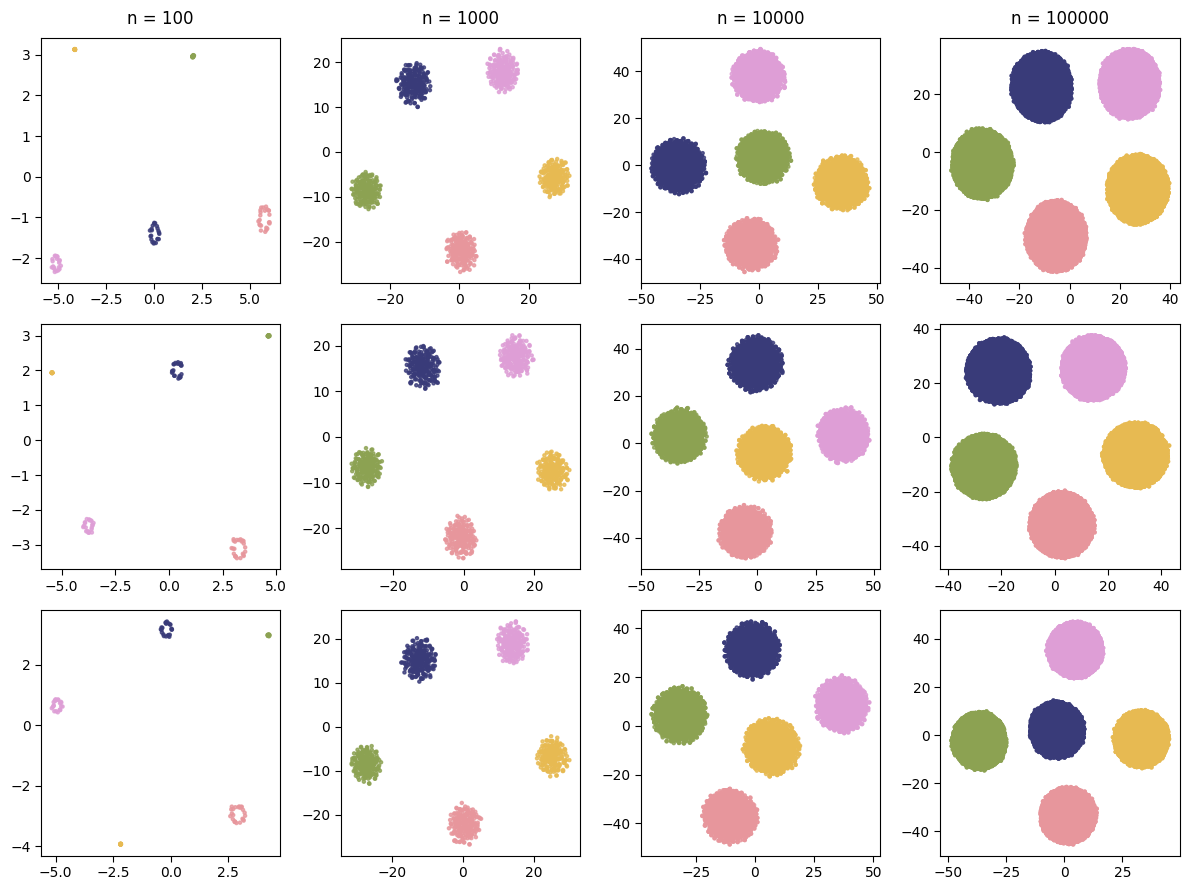

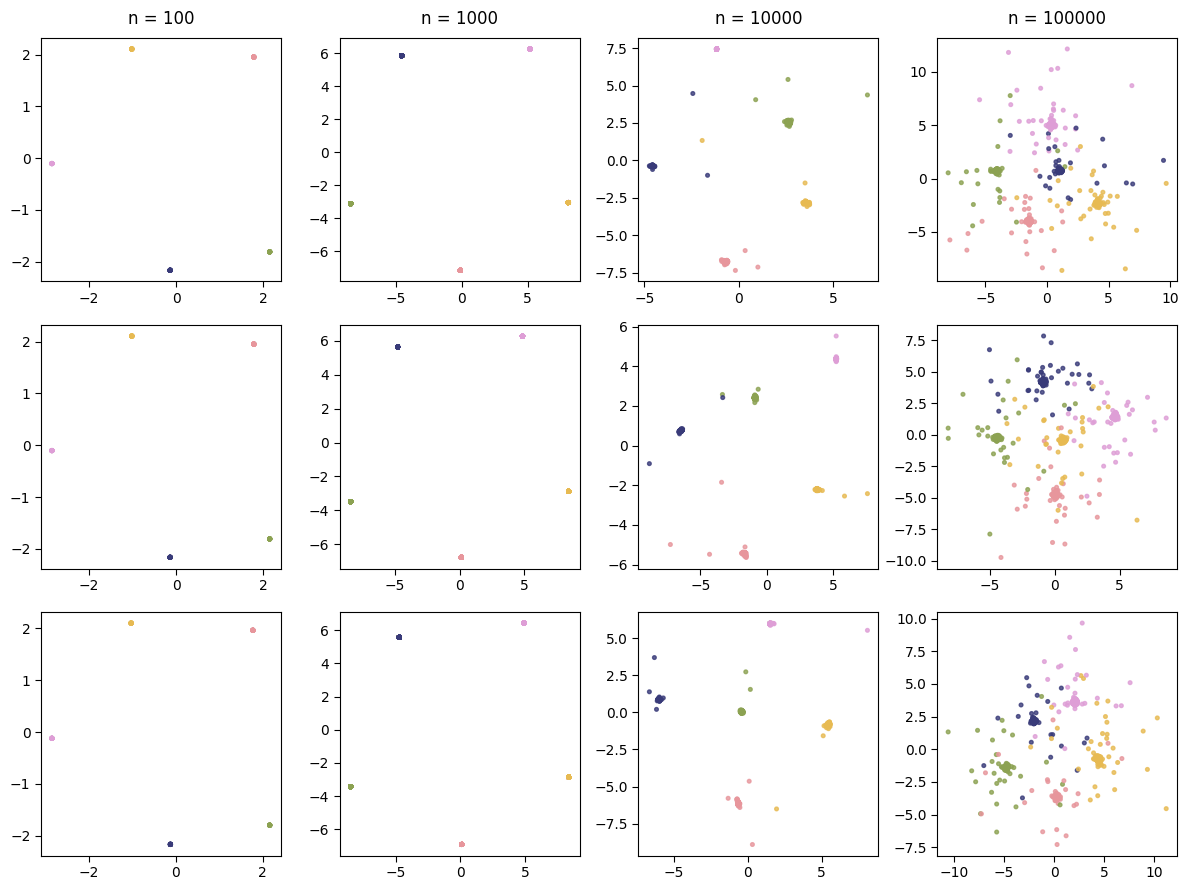

In [ ]:
plot_embedding_grid(embedding_dict, seeds, data_sizes, "Gaussian_Mixture", "standard")
plot_embedding_grid(embedding_dict, seeds, data_sizes, "Gaussian_Mixture", "rescaled")

In [79]:
data_sizes_4 = [100, 1000, 10000, 70000]
embedding_mnist = generate_embedding_dict_mnist(data_sizes_4, seeds, b=0.15, kappa=20)

n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 25.18 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 3.98
n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 25.18 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 3.98
n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 25.18 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 3.98
n = 1000, d = 50, b=0.15
Computed h_n = 0.3548
Using perplexity = 28.25 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 7.94
n = 1000, d = 50, b=0.15
Computed h_n = 0.3548
Using perplexity = 28.25 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 7.94
n = 1000, d = 50, b=0.15
Computed h_n = 0.3548
Using perplexity = 28.25 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 7.94
n = 10000, d = 50, b=0.15
Computed h_n = 0.2512
Using perplexity = 31.70 (base κ = 20, exponent α = 0.05)
Using early exaggeration = 15.85
n = 10000, d = 50, b=0.15
Computed h_n = 0

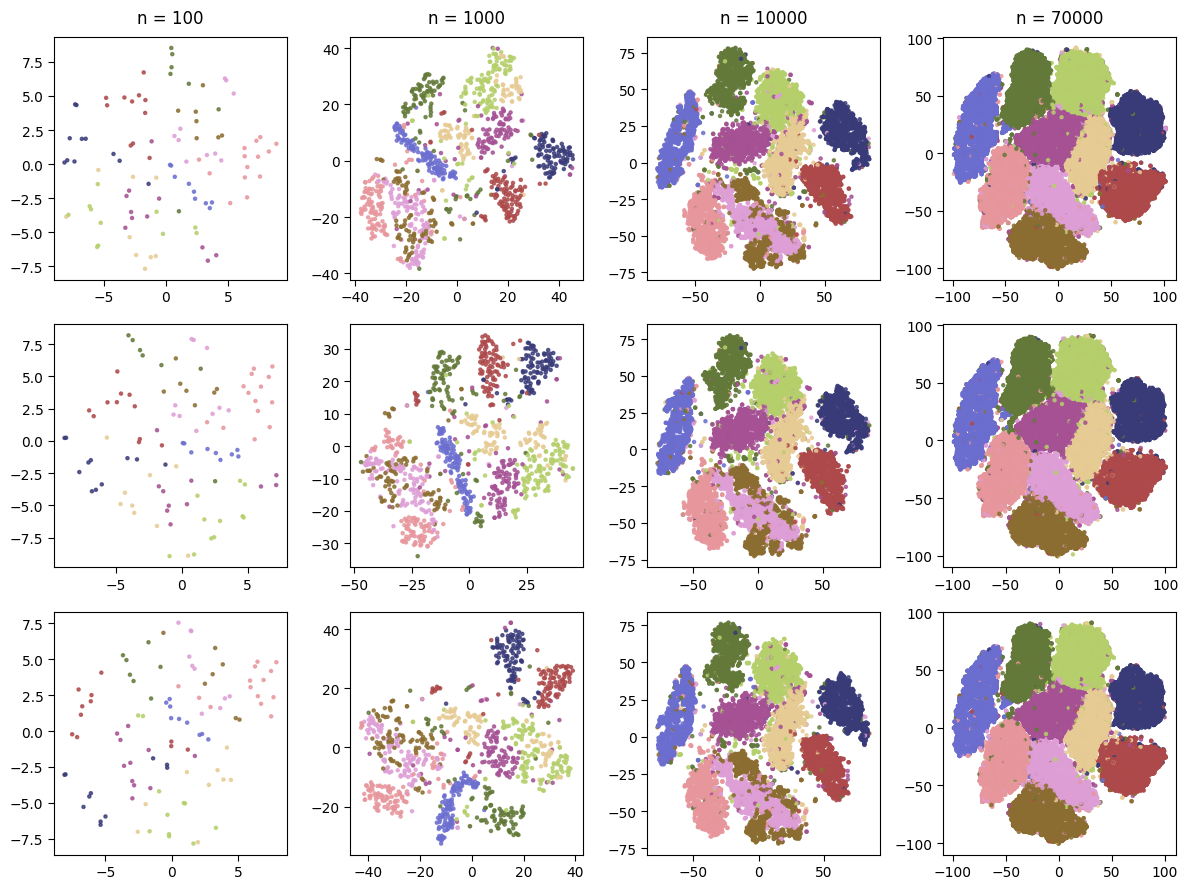

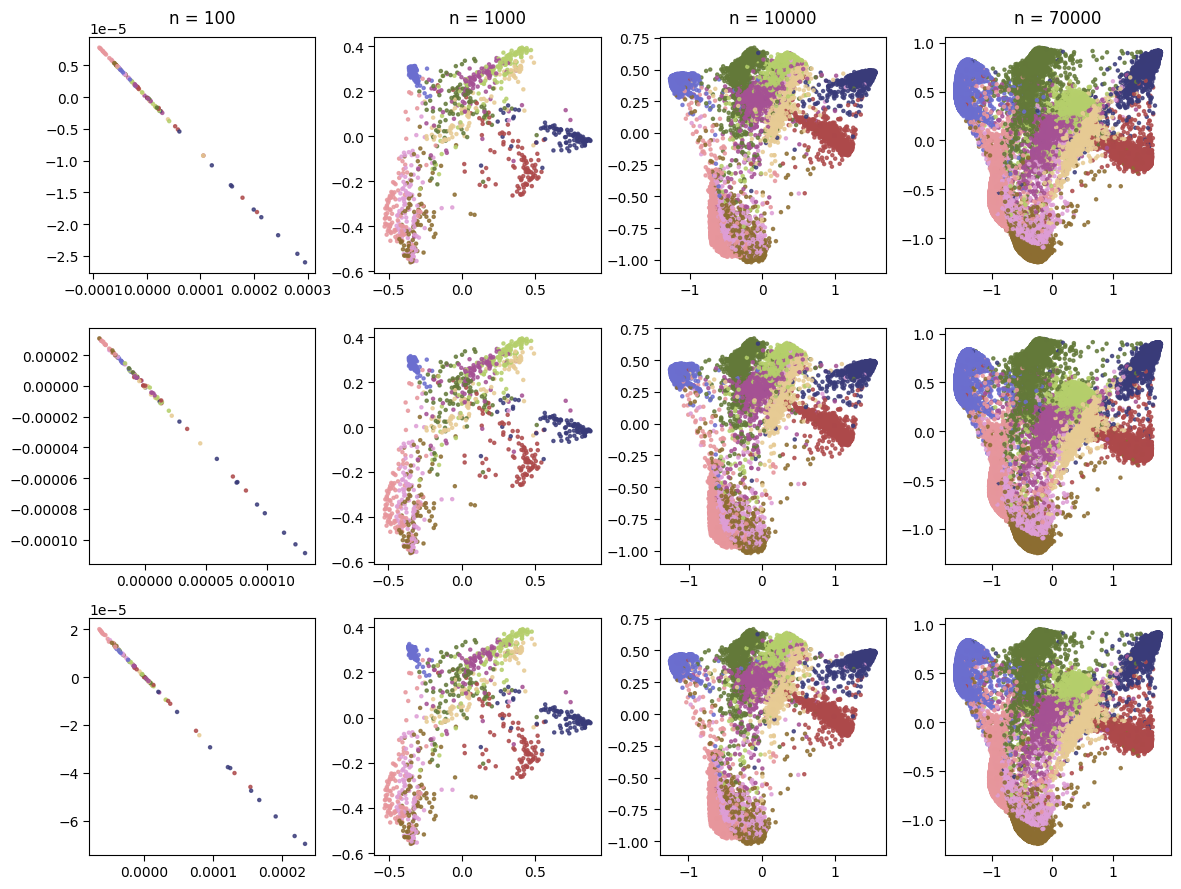

In [80]:
plot_embedding_grid(embedding_mnist, seeds, data_sizes_4, "MNIST", "standard")
plot_embedding_grid(embedding_mnist, seeds, data_sizes_4, "MNIST", "rescaled")

In [ ]:
embedding_mnist2 = generate_embedding_dict_mnist(data_sizes_4, seeds, b=0.07, kappa=15)
embedding_gaussian2 = generate_embedding_dict_gaussian(gaussian_data, data_sizes, seeds, b=0.07, kappa=15)

In [ ]:
plot_embedding_grid(embedding_gaussian2, seeds, data_sizes, "Gaussian_Mixture", "standard")
plot_embedding_grid(embedding_gaussian2, seeds, data_sizes, "Gaussian_Mixture", "rescaled")

In [ ]:
plot_embedding_grid(embedding_mnist2, seeds, data_sizes_4, "MNIST", "standard")
plot_embedding_grid(embedding_mnist2, seeds, data_sizes_4, "MNIST", "rescaled")

In [ ]:
embedding_mnist3 = generate_embedding_dict_mnist(data_sizes_4, seeds, b=0.05, kappa=15)
embedding_gaussian3 = generate_embedding_dict_gaussian(gaussian_data, data_sizes, seeds, b=0.05, kappa=15)

In [ ]:
plot_embedding_grid(embedding_gaussian3, seeds, data_sizes, "Gaussian_Mixture", "standard")
plot_embedding_grid(embedding_gaussian3, seeds, data_sizes, "Gaussian_Mixture", "rescaled")
plot_embedding_grid(embedding_mnist3, seeds, data_sizes_4, "MNIST", "standard")
plot_embedding_grid(embedding_mnist3, seeds, data_sizes_4, "MNIST", "rescaled")

In [ ]:
embedding_mnist4 = generate_embedding_dict_mnist(data_sizes_4, seeds, b=0.03, kappa=15)
embedding_gaussian4 = generate_embedding_dict_gaussian(gaussian_data, data_sizes, seeds, b=0.03, kappa=15)

In [ ]:
plot_embedding_grid(embedding_gaussian4, seeds, data_sizes, "Gaussian_Mixture", "standard")
plot_embedding_grid(embedding_gaussian4, seeds, data_sizes, "Gaussian_Mixture", "rescaled")
plot_embedding_grid(embedding_mnist4, seeds, data_sizes_4, "MNIST", "standard")
plot_embedding_grid(embedding_mnist4, seeds, data_sizes_4, "MNIST", "rescaled")

In [ ]:
embedding_mnist5 = generate_embedding_dict_mnist(data_sizes_4, seeds, b=0.07, kappa=20)
embedding_gaussian5 = generate_embedding_dict_gaussian(gaussian_data, data_sizes, seeds, b=0.07, kappa=20)

In [ ]:
plot_embedding_grid(embedding_gaussian5, seeds, data_sizes, "Gaussian_Mixture", "standard")
plot_embedding_grid(embedding_gaussian5, seeds, data_sizes, "Gaussian_Mixture", "rescaled")
plot_embedding_grid(embedding_mnist5, seeds, data_sizes_4, "MNIST", "standard")
plot_embedding_grid(embedding_mnist5, seeds, data_sizes_4, "MNIST", "rescaled")

In [ ]:
embedding_mnist6 = generate_embedding_dict_mnist(data_sizes_4, seeds, b=0.07, kappa=10)
embedding_gaussian6 = generate_embedding_dict_gaussian(gaussian_data, data_sizes, seeds, b=0.07, kappa=10)

In [ ]:
plot_embedding_grid(embedding_gaussian6, seeds, data_sizes, "Gaussian_Mixture", "standard")
plot_embedding_grid(embedding_gaussian6, seeds, data_sizes, "Gaussian_Mixture", "rescaled")
plot_embedding_grid(embedding_mnist6, seeds, data_sizes_4, "MNIST", "standard")
plot_embedding_grid(embedding_mnist6, seeds, data_sizes_4, "MNIST", "rescaled")